In [37]:
import numpy as np
import pandas as pd
import seaborn as sns

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open('drive/MyDrive/data/birdnet_clef/emb_cube.npy', 'rb') as f:
    emb_cube = np.load(f)


In [5]:
emb_cube.shape

(1841, 25, 320)

In [6]:
meta_df_cut = pd.read_parquet("drive/MyDrive/data/birdnet_clef/meta_df_cut.pq")
meta_df_cut.drop(columns=["license", "sample_rate", "author", "details"], inplace=True)
print(meta_df_cut.shape)
meta_df_cut.head()

(1841, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,rating,time,url,filename,length
0,afrsil1,[],['call'],21.3561,-158.0205,Euodice cantans,African Silverbill,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg,42.866937
1,afrsil1,[],['call'],17.1003,54.2844,Euodice cantans,African Silverbill,4.5,06:35,https://www.xeno-canto.org/395771,afrsil1/XC395771.ogg,27.219000
2,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg,29.328000
3,akiapo,[],['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,5.0,12:00,https://www.xeno-canto.org/306424,akiapo/XC306424.ogg,29.910219
4,aniani,[],['call'],22.1467,-159.6134,Magumma parva,Anianiau,4.0,09:00,https://www.xeno-canto.org/210203,aniani/XC210203.ogg,42.083250


In [7]:
df = pd.read_parquet(
    "https://storage.googleapis.com/birdclef-eda-f22/data/processed/birdnet/birdnet_analyze_v1.parquet"
)
label = df[(df["end_sec"]<=27)&(df.confidence >= 0.0)].groupby("filename").agg({
    'birdnet_label':'nunique',
    'start_sec': 'nunique',
    'confidence': 'max'
})

In [8]:
meta_df_cut = meta_df_cut.join(label, on="filename", how="left")

In [9]:
meta_df_cut.fillna(0, inplace=True)

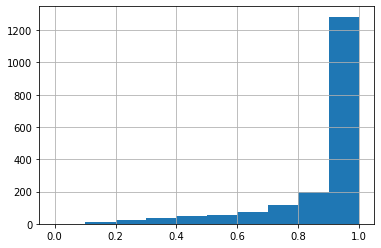

In [10]:
meta_df_cut.confidence.hist()

In [11]:
meta_df_cut["have_bird"] = (meta_df_cut["confidence"] >= 0.9).astype(int)

In [12]:
meta_df_cut["have_bird"].value_counts()

1    1283
0     558
Name: have_bird, dtype: int64

In [13]:
emb_cube.shape

(1841, 25, 320)

In [14]:
meta_df_cut["emb_2d"] = pd.Series(meta_df_cut.index.to_list()).apply(lambda x: emb_cube[x,:,:])
meta_df_cut

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,rating,time,url,filename,length,birdnet_label,start_sec,confidence,have_bird,emb_2d
0,afrsil1,[],['call'],21.356100,-158.020500,Euodice cantans,African Silverbill,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg,42.866937,8.0,9.0,0.9973,1,"[[2.397629, 1.2727937, 1.6924118, 0.96529645, ..."
1,afrsil1,[],['call'],17.100300,54.284400,Euodice cantans,African Silverbill,4.5,06:35,https://www.xeno-canto.org/395771,afrsil1/XC395771.ogg,27.219000,4.0,9.0,0.9633,1,"[[1.7683223, 1.600648, 0.18377368, 1.3941551, ..."
2,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.629400,-155.361500,Hemignathus wilsoni,Akiapolaau,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg,29.328000,5.0,6.0,0.9284,1,"[[1.8520132, 0.5456287, 1.445063, 1.0568457, 0..."
3,akiapo,[],['song'],19.629400,-155.361500,Hemignathus wilsoni,Akiapolaau,5.0,12:00,https://www.xeno-canto.org/306424,akiapo/XC306424.ogg,29.910219,6.0,9.0,0.9844,1,"[[2.087037, 0.18106456, 0.10568639, 1.3522729,..."
4,aniani,[],['call'],22.146700,-159.613400,Magumma parva,Anianiau,4.0,09:00,https://www.xeno-canto.org/210203,aniani/XC210203.ogg,42.083250,3.0,5.0,0.8021,0,"[[1.4449097, 0.52302724, 0.900517, 0.8686587, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,zebdov,[],['song'],18.670800,98.655000,Geopelia striata,Zebra Dove,4.0,10:30,https://www.xeno-canto.org/447638,zebdov/XC447638.ogg,40.568156,3.0,7.0,0.9038,1,"[[1.0385655, 1.0618016, 1.1200749, 0.37138078,..."
1837,zebdov,[],['call'],12.554200,102.047200,Geopelia striata,Zebra Dove,4.0,10:30,https://www.xeno-canto.org/559916,zebdov/XC559916.ogg,33.985000,4.0,9.0,0.8735,0,"[[1.0912341, 1.216385, 1.4629607, 1.2032481, 0..."
1838,zebdov,[],['Call'],-7.831191,114.387551,Geopelia striata,Zebra Dove,5.0,10:21,https://www.xeno-canto.org/578384,zebdov/XC578384.ogg,31.555000,10.0,8.0,0.9239,1,"[[1.1606328, 1.2192922, 0.89963084, 0.9660534,..."
1839,zebdov,[],['song'],18.293500,99.500700,Geopelia striata,Zebra Dove,5.0,08:00,https://www.xeno-canto.org/598171,zebdov/XC598171.ogg,33.358000,2.0,7.0,0.9381,1,"[[1.0999609, 0.80271655, 0.6590689, 0.6796887,..."


In [15]:
data = meta_df_cut[["filename","have_bird","emb_2d"]].copy()
data

,filename,have_bird,emb_2d
0,afrsil1/XC209513.ogg,1,"[[2.397629, 1.2727937, 1.6924118, 0.96529645, ..."
1,afrsil1/XC395771.ogg,1,"[[1.7683223, 1.600648, 0.18377368, 1.3941551, ..."
2,akiapo/XC122399.ogg,1,"[[1.8520132, 0.5456287, 1.445063, 1.0568457, 0..."
3,akiapo/XC306424.ogg,1,"[[2.087037, 0.18106456, 0.10568639, 1.3522729,..."
4,aniani/XC210203.ogg,0,"[[1.4449097, 0.52302724, 0.900517, 0.8686587, ..."
...,...,...,...
1836,zebdov/XC447638.ogg,1,"[[1.0385655, 1.0618016, 1.1200749, 0.37138078,..."
1837,zebdov/XC559916.ogg,0,"[[1.0912341, 1.216385, 1.4629607, 1.2032481, 0..."
1838,zebdov/XC578384.ogg,1,"[[1.1606328, 1.2192922, 0.89963084, 0.9660534,..."
1839,zebdov/XC598171.ogg,1,"[[1.0999609, 0.80271655, 0.6590689, 0.6796887,..."


In [16]:
# Develop RNN model

class GRUClf(nn.Module):
    def __init__(self, emb_dim = 320, output_size=1, gru_size=64, drop_prob=0.1, 
            gru_num_layer=8, bidirectional=False, decoder_depth=3, decoder_size = [256, 512, 64],
            word_embedding='glove-wiki-gigaword-200'):
        super().__init__()
        self.emb_dim = emb_dim
        if decoder_depth != len(decoder_size):
            raise ValueError("decoder_depth must be equal to len(decoder_size)")

        self.gru_size = gru_size
        self.gru_num_layer = gru_num_layer
        self.decoder_depth = decoder_depth
        self.decoder_size = decoder_size
        self.output_size = output_size
        self.gru = nn.GRU(
            input_size = self.emb_dim, 
            hidden_size = gru_size, 
            num_layers = gru_num_layer, 
            bias = True,
            batch_first=True, 
            dropout=drop_prob,
            bidirectional=bidirectional)
        
        self.num_channel_hidden_out = gru_num_layer
        if bidirectional:
            self.num_channel_hidden_out *= 2
        
        self.size_hidden_out = self.num_channel_hidden_out * gru_size

        if decoder_depth == 1:
            decoder_mlp = nn.Sequential(
                nn.Linear(self.size_hidden_out, decoder_size[0]),
                nn.ReLU(),
                nn.Linear(decoder_size[0], output_size)
            )
        elif decoder_depth == 2:
            decoder_mlp = nn.Sequential(
                nn.Linear(self.size_hidden_out, decoder_size[0]),
                nn.ReLU(),
                nn.Linear(decoder_size[0], decoder_size[1]),
                nn.ReLU(),
                nn.Linear(decoder_size[1], output_size)
            )
        elif decoder_depth == 3:
            decoder_mlp = nn.Sequential(
                nn.Linear(self.size_hidden_out, decoder_size[0]),
                nn.ReLU(),
                nn.Linear(decoder_size[0], decoder_size[1]),
                nn.ReLU(),
                nn.Linear(decoder_size[1], decoder_size[2]),
                nn.ReLU(),
                nn.Linear(decoder_size[2], output_size)
            )
        elif decoder_depth == 4:
            decoder_mlp = nn.Sequential(
                nn.Linear(self.size_hidden_out, decoder_size[0]),
                nn.ReLU(),
                nn.Linear(decoder_size[0], decoder_size[1]),
                nn.ReLU(),
                nn.Linear(decoder_size[1], decoder_size[2]),
                nn.ReLU(),
                nn.Linear(decoder_size[2], decoder_size[3]),
                nn.ReLU(),
                nn.Linear(decoder_size[3], output_size)
            )

        self.task1_mlp = deepcopy(decoder_mlp)


        
    
    def forward(self, input_data):
        batch_size = input_data.shape[0]
        x_pack = pack_padded_sequence(input_data, torch.tensor([25]* batch_size), batch_first=True, enforce_sorted=False)
        # x_pack = input_data
        # print("after pack", x_pack.data.shape)
        _, ht = self.gru(x_pack)
        ht = ht.permute((1,0,2))
        ht = ht.reshape(batch_size, self.size_hidden_out)
        out = self.task1_mlp(torch.relu(ht))
        # out = nn.Sigmoid()(out)
        return torch.sigmoid(out)

In [17]:
class BirdDataset(Dataset):
    def __init__(self, data, input_col, label_col):
        super().__init__()
        self.data = data.reset_index()
        self.input_col = input_col
        self.label_col = label_col

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        # return x, y, s - s is the length of the input sequence
        
        x = self.data.loc[idx,self.input_col]
        y = self.data.loc[idx,self.label_col]
        
        return x, y

def collate_fn(batch):
    inputs = [x[0] for x in batch]    
    labels = [x[1] for x in batch]
    return torch.tensor(inputs), torch.tensor(labels)

In [18]:
model = GRUClf(output_size=1,
               gru_size=32,
               drop_prob=0.1,
               gru_num_layer=3,
               bidirectional=False,
               decoder_depth=1,
               decoder_size=[256])

In [19]:
def train_clf(train_dl, valid_dl, model, model_name, loss_func, 
    opt, save_path=".", epochs=1, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_eval_loss = float('inf')
    eval_loss_list = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            yb = torch.unsqueeze(yb,1)
            yb = yb.to(torch.float32)
            # print(yb.dtype)
            # print(yb.shape)
            yb_pred = model(xb)
            # print(yb_pred.dtype)
            # print(yb_pred.shape)
            loss = loss_func(yb_pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            train_loss = sum(
                loss_func(model(xb.to(device)),
                    torch.unsqueeze(yb.to(device).to(torch.float32),1)
                    ) for (xb), yb in train_dl
            )
            valid_loss = sum(
                loss_func(model(xb.to(device)),
                    torch.unsqueeze(yb.to(device).to(torch.float32),1)
                    ) for (xb), yb in valid_dl)
        tl = (train_loss / len(train_dl)).cpu().numpy()
        vl = (valid_loss / len(valid_dl)).cpu().numpy()
        if vl < best_eval_loss and vl > tl:
            best_eval_loss = vl
            best_model = deepcopy(model)
            torch.save(model.state_dict(), f'{save_path}/best_{model_name}.pt')
        eval_loss_list.append(vl)
        print(f"Epoch {epoch:04}, train loss: {tl:.6f}, valid loss: {vl:.6f}, best valid loss: {best_eval_loss:.6f}")
        if epoch > 5 and min(eval_loss_list[-10:]) > best_eval_loss:
            print(f"Early stopping, best valid loss: {best_eval_loss:.6f}")
            break
    # best_model = torch.load(f'best_model_{model_name}.pt')
    best_model.eval()
    return best_model

# Modeling

In [21]:
df_train, df_valid, df_test = np.split(
    data.sample(
        frac=1, random_state=42), 
    [int(.8*len(data)), int(.9*len(data))])

## Baseline

In [54]:
df_test

,filename,have_bird,emb_2d
524,comsan/XC646457.ogg,1,"[[1.3648381, 0.47757056, 0.9585522, 0.96576434..."
1059,mallar3/XC628151.ogg,0,"[[1.0349622, 1.2719097, 0.21966143, 0.19584866..."
540,comwax/XC348462.ogg,1,"[[1.3619212, 1.4887191, 1.3967752, 1.1579536, ..."
1194,norcar/XC609232.ogg,1,"[[0.7208845, 1.2440221, 1.4025162, 0.56412774,..."
748,gwfgoo/XC602729.ogg,0,"[[1.089777, 1.1946472, 1.1867837, 0.28701344, ..."
...,...,...,...
1130,norcar/XC233123.ogg,0,"[[0.4482822, 0.99948674, 1.3930095, 0.37808052..."
1294,osprey/XC518341.ogg,1,"[[1.1058484, 0.9110319, 0.2624757, 0.83693314,..."
860,houspa/XC502429.ogg,1,"[[1.2324969, 1.7428583, 0.94073844, 1.6044816,..."
1459,rocpig/XC302293.ogg,1,"[[1.6655306, 0.44840065, 1.5148406, 1.0536193,..."


In [93]:
col_1d = [f"a{i}" for i in range(320)]

In [90]:
|df_train["emb_1d"] = df_train["emb_2d"].apply(lambda x: np.mean(x, axis=0))
for i in range(320):
    df_train[f"a{i}"] = df_train["emb_1d"].apply(lambda x: x[i])
df_train.shape

<ipython-input-90-e9a2206850db>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[f"a{i}"] = df_train["emb_1d"].apply(lambda x: x[i])


(1472, 324)

In [91]:
df_test["emb_1d"] = df_test["emb_2d"].apply(lambda x: np.mean(x, axis=0))
for i in range(320):
    df_test[f"a{i}"] = df_test["emb_1d"].apply(lambda x: x[i])
df_test.shape

<ipython-input-91-cd979106f3f2>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[f"a{i}"] = df_test["emb_1d"].apply(lambda x: x[i])


(185, 324)

In [101]:
X_train_ = df_train[["have_bird"] + col_1d].copy()
y_train_ = df_train["have_bird"].copy()
X_test_ = df_test[["have_bird"] + col_1d].copy()
y_test_ = df_test["have_bird"].copy()

In [100]:
base_model = Pipeline(steps=[
    ("pca", PCA(n_components=32)),
    ("lgbm", LGBMClassifier())
])
base_model

Pipeline(steps=[('pca', PCA(n_components=32)), ('lgbm', LGBMClassifier())])

In [102]:
base_model.fit(X_train_, y_train_)

Pipeline(steps=[('pca', PCA(n_components=32)), ('lgbm', LGBMClassifier())])

In [106]:
y_base_pred = base_model.predict(X_test_)
print(classification_report(y_test_, y_base_pred))

              precision    recall  f1-score   support

           0       0.78      0.60      0.68        63
           1       0.82      0.91      0.86       122

    accuracy                           0.81       185
   macro avg       0.80      0.76      0.77       185
weighted avg       0.80      0.81      0.80       185



In [105]:
roc_auc_score(y_test_, base_model.predict_proba(X_test_)[:,1])

0.8701535258912307

# Recurrent neural network model

In [22]:
INP_COL = "emb_2d"
LAB_COL = "have_bird"
BATCH_SIZE = 64
dl_train = DataLoader(BirdDataset(df_train, INP_COL, LAB_COL), 
                      batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dl_valid = DataLoader(BirdDataset(df_valid, INP_COL, LAB_COL), 
                      batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(BirdDataset(df_test, INP_COL, LAB_COL), 
                      batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [23]:
best_model = train_clf(dl_train, dl_valid, 
        model=model,
        model_name="init",
        save_path="drive/MyDrive/data/birdnet_clef/train_tmp",
        loss_func=torch.nn.BCELoss(),
        opt=torch.optim.Adam(model.parameters(), lr=0.001),
        epochs=50)

<ipython-input-17-df13c46b81c0>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(inputs), torch.tensor(labels)


Epoch 0000, train loss: 0.609375, valid loss: 0.610087, best valid loss: 0.610087
Epoch 0001, train loss: 0.604621, valid loss: 0.608185, best valid loss: 0.608185
Epoch 0002, train loss: 0.591453, valid loss: 0.599178, best valid loss: 0.599178
Epoch 0003, train loss: 0.593541, valid loss: 0.603517, best valid loss: 0.599178
Epoch 0004, train loss: 0.557402, valid loss: 0.571878, best valid loss: 0.571878
Epoch 0005, train loss: 0.566248, valid loss: 0.584455, best valid loss: 0.571878
Epoch 0006, train loss: 0.535381, valid loss: 0.577671, best valid loss: 0.571878
Epoch 0007, train loss: 0.536820, valid loss: 0.546716, best valid loss: 0.546716
Epoch 0008, train loss: 0.497190, valid loss: 0.550093, best valid loss: 0.546716
Epoch 0009, train loss: 0.464569, valid loss: 0.528468, best valid loss: 0.528468
Epoch 0010, train loss: 0.454084, valid loss: 0.515440, best valid loss: 0.515440
Epoch 0011, train loss: 0.437341, valid loss: 0.510207, best valid loss: 0.510207
Epoch 0012, trai

In [24]:
y_pred_proba = []
best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for xb, yb in dl_test:
        y_pred_proba.append(best_model(xb.to(device)).cpu().numpy())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:958: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, batch_sizes, hx, self._flat_weights, self.bias,


In [25]:
[len(x) for x in y_pred_proba]

[64, 64, 57]

In [26]:
# classification report
from sklearn.metrics import classification_report
y_pred_proba = np.concatenate(y_pred_proba).flatten()

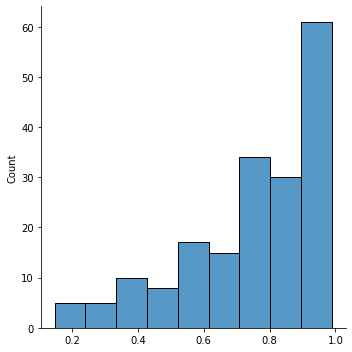

In [61]:
sns.displot(y_pred_proba)

In [72]:
df_score = pd.DataFrame(columns=["thres", "precision", "recall", "f1_score"])
for thres in np.linspace(0,1,num=100, endpoint=False):
    pre = precision_score(df_test['have_bird'], (y_pred_proba > thres).astype(int))
    rec = recall_score(df_test['have_bird'], (y_pred_proba > thres).astype(int))
    f1s = f1_score(df_test['have_bird'], (y_pred_proba > thres).astype(int))
    df_score.loc[len(df_score)] = [thres, pre, rec, f1s]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
df_plot = df_score.set_index("thres").unstack().to_frame("score").reset_index().rename(
    columns={"level_0":"type"})
df_plot

,type,thres,score
0,precision,0.00,0.659459
1,precision,0.01,0.659459
2,precision,0.02,0.659459
3,precision,0.03,0.659459
4,precision,0.04,0.659459
...,...,...,...
295,f1_score,0.95,0.405229
296,f1_score,0.96,0.305556
297,f1_score,0.97,0.192593
298,f1_score,0.98,0.123077


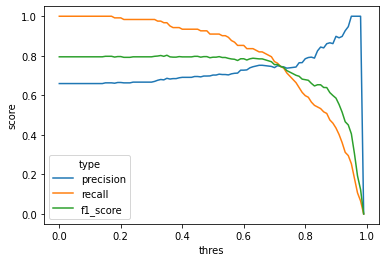

In [74]:
sns.lineplot(data=df_plot, x="thres", y="score", hue="type")

In [75]:
print(classification_report(df_test['have_bird'], (y_pred_proba > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.59      0.25      0.36        63
           1       0.70      0.91      0.79       122

    accuracy                           0.69       185
   macro avg       0.65      0.58      0.57       185
weighted avg       0.67      0.69      0.64       185



In [76]:
roc_auc_score(df_test['have_bird'], y_pred_proba)

0.7155867811605517

# Conclusion

Using pre-trained embeddings, the baseline model using PCA and tree-based classifier achieved very good classification performance, reaching a roc_auc_score of 0.87 on the test set.

The more complex model like recurrent neural network only achieved a roc_auc_score of 0.71, indicating that the architechture is not appropriate for the task at hand or the dataset.